**The Battle of Neighborhoods**

**1. Introduction**

The purpose of this project is to help anyone interested in exploring and prospecting the best area in NYC to setup a restaurant specifically related to exclusive french cuisine.

By applying Data Science in our research, the findings may help people understand and make smart decisions when ready to go live and setup a similar business.

Finally, this methodology could be replicated and applied to other cities around the globe as long as the Data Scientist has access to a data base of the city to be analysed.

**2. Business Problem**

The restaurant industry is certainly a <u>difficult</u> business to set up and operate not only because it’s capital-intensive with <u>low margins</u> but due to health issues, they’re also under heavy regulations. In top, most restaurants have to deal with a large number of skill-full and hard-working <u>competitors</u> and a variety of flavours worldwide.

Depending whether restaurants want to crack a particular segment and remain prosperous, they have to run a proper analysis of this particular industry with reliable and predictive data tools. Indeed, Data science provides invaluable insights regarding trends and emerging consumer lifestyles so that they can better address and meet public needs. 

For this project, I will use the Foursquare API to <u>explore</u> neighbourhoods in New York City in order to figure out the best location for me to open a French restaurant and position it in a <u>niche</u> sector. In addition, the explore function will let us get the most common venue categories in each neighbourhood, and then we’ll use this feature to group them into neighbourhoods. Then we’ll figure out which location is the most common visit venue and venue with least/most french restaurants to help me to decide the <u>optimum location</u> for opening a french restaurant. As a side note, the data source and methodology will be described in the 2nd part of the project.

By applying Data Science, we need to address a few questions:
* What's currently the best are in NYC to taste exclusive French cuisine?
* What is the best area in NYC for French restaurants?
* Which areas New Yorkers relate to French cuisine?

**3. Target Audience¶**

As we known, New York city is probably one of the most important financial centre in the world and also described as a great influencer in terms of new culture, fashion, commerce, entertainment, sport, financial research, tourism, comtemporary art, sports and cuisine. Because of the great melting pot and large foreign communities, it's quite beneficial for New Yorkes as they can get a <u>large variety</u> of choice in terms of fine cuisine such as: chinese, indian, italian, thai, peruvian, japanese to mention a few.

Having said this, we also have to keep in mind french cuisine is probably one of the most expensive cuisine out there and, in this respect, prospect areas should be selected on this particular criteria.

Finally, to survive in this competitive market, as a whole, ensuring a <u>correct location</u> for a business in the restaurant industry is key.

**4. Data Source**

* We will use the existing free New York Geo data: https://cocl.us/new_york_dataset to determine the number of borough and neighbourhoods.

* In order to segment the neighbourhoods and explore them, we will essentially need a dataset that contains the boroughs and neighbourhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighbourhood.

* We will be using FourSquare API to find all venues for each neighbourhood.

* Then we’ll filter out all venues that are French Restaurants

* Next, we’ll find and count the ratings, tips and likes for each French Restaurant using FourSquare API and sort the data

* Finally, we’ll visualise the ranking of neighbourhoods using folium library(python)

**5. Methodology**

The FourSquare API is used as its prime data gathering source as it has a database of millions of places, especially their places API which provides the ability to explore specific location, location sharing and details about a business. Client_ID and Client_Secret serial numbers provided when registering in their website allow us to access to their API and geodata with a limited number of calls.

Also, matplotlib and pandas libraries are deployed to help us to manipulate data structures and then create static plots with python

**Analysis**

In [141]:
!conda install -c conda-forge geocoder --yes
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [142]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [143]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # changed my Foursquare ID
    CLIENT_SECRET = '' # changed Foursquare Secret
    VERSION = '20181027' # Foursquare API version: 20200713
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [144]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '' # i have changed the id with ##
    CLIENT_SECRET = '' # i have changed the secret with ##
    VERSION = '20181027' # Foursquare API version: 20200713
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [145]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [146]:
# get new york data
new_york_data = get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [147]:
new_york_data.shape

(306, 4)

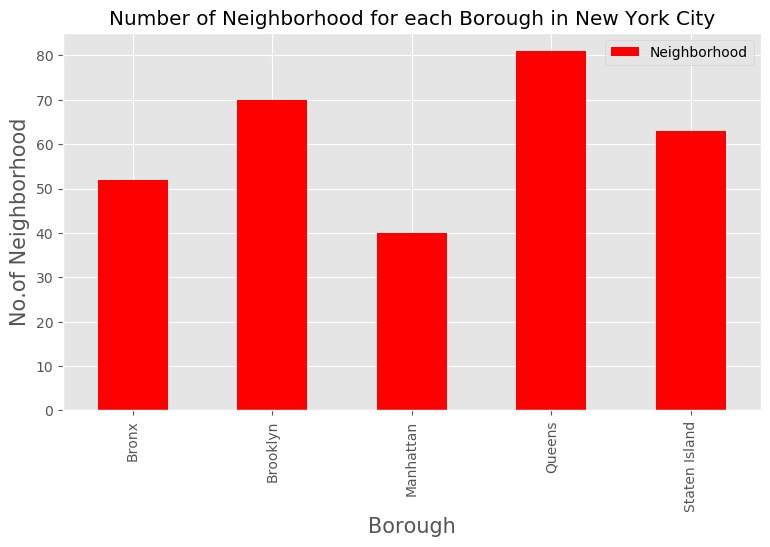

In [148]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='red')
#legend
plt.legend()
#displays the plot
plt.show()

In [149]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny = pd.DataFrame(columns=column_names) # asian_rest_ny to french_rest_ny
count=1

#print('French restaurants in\n---------------------')

for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    # asian_resturants=venues[venues['Category']=='Asian Restaurant']
    french_resturants = venues[venues['Category'] == 'French Restaurant']
    # print('(',count,'/',len(new_york_data),')','Asian Resturants in '+Neighborhood+', '+Borough+':'+str(len(asian_resturants)))
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    # for resturant_detail in asian_resturants.values.tolist():
    for restaurant_detail in french_resturants.values.tolist():
        id, name , category = restaurant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

print('List containing all French restaurants completed')

done
( 1 / 306 ) French Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) French Resturants in Norwood, Bronx:0
done
( 10 / 306 ) French Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) French Resturants in Baychester, Bronx:0
done
( 12 / 306 ) French Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) French Resturants in City Island, Bronx:1
done
( 14 / 306 ) French Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) French Resturants in University Heights, Bronx:0
done
( 16 / 306 ) French Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) French Resturants in Ford

In [150]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock


In [151]:
french_rest_ny.shape

(82, 4)

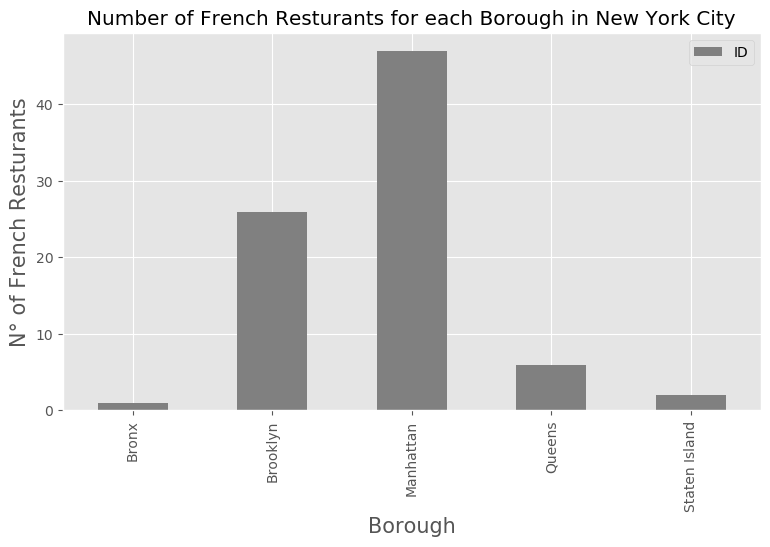

In [152]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('N° of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color="grey")
#legend
plt.legend()
#displays the plot
plt.show()

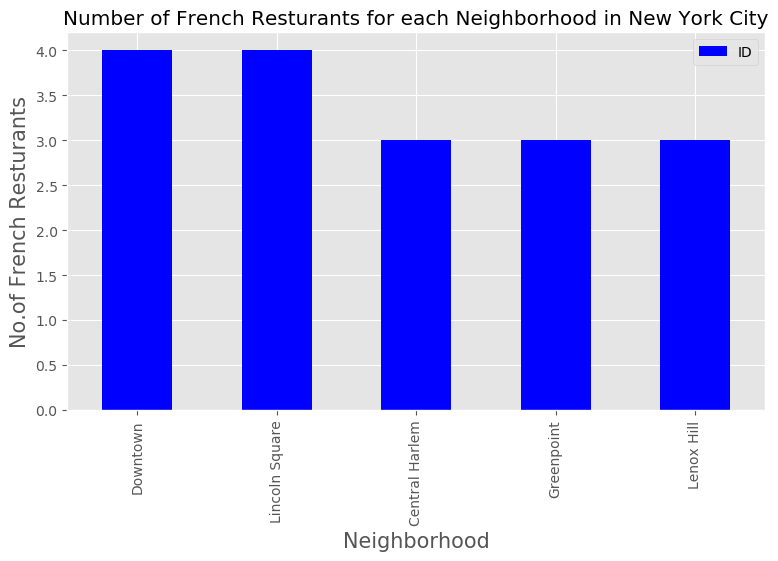

In [153]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color='blue')
#legend
plt.legend()
#displays the plot
plt.show()

In [154]:
french_rest_ny[french_rest_ny['Neighborhood']=='Downtown']

,Borough,Neighborhood,ID,Name
17,Brooklyn,Downtown,530931a5498e4079544a5f13,French Louie
18,Brooklyn,Downtown,4d20bc3af7a9a143bcab2f9f,The Little Sweet Café
19,Brooklyn,Downtown,5250553911d262bb0c732ee8,Cafe Paulette
20,Brooklyn,Downtown,3fd66200f964a52058f11ee3,Bar Tabac


In [155]:
# prepare the list of neighborhood having french resturants

column_names=['Borough','Neighborhood','ID','Name','Likes','Rating','Tips']
french_rest_stats_ny = pd.DataFrame(columns=column_names)
count=1


for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id = ',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips = [0]*5
    print('(',count,'/',len(french_rest_ny),')','processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    
print('List of neighbourhood containing French restaurants completed')

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     13     7.5     7
( 1 / 82 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bf358689fca56002c251a87  Citroën     21     8.3     3
( 2 / 82 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    212     8.8    59
( 3 / 82 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    158     7.8    73
( 4 / 82 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    135     8.7    56
( 5 / 82 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4aee2d5cf964a520b7d221e3  Le P'tit Paris Bistro     55     7.5    32
( 6 / 82 ) processed
                         ID       Name  Likes  Rating  Tips
0  50b99e4ae4b0c22ba9633dfd  Mominette    340     8.4    80
( 7 / 

In [156]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,21,8.3,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,212,8.8,59
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,7.8,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.7,56


In [157]:
french_rest_ny.shape

(82, 4)

In [158]:
french_rest_stats_ny.to_csv('french_rest_stats_ny.csv', index=False)

In [159]:
french_rest_stats_ny_csv = pd.read_csv('french_rest_stats_ny.csv')
french_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,21,8.3,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,212,8.8,59
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,7.8,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.7,56


In [160]:
french_rest_stats_ny['Likes'] = french_rest_stats_ny['Likes'].astype('float64')

In [161]:
french_rest_stats_ny['Tips'] = french_rest_stats_ny['Tips'].astype('float64')

In [162]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       82 non-null     object 
 1   Neighborhood  82 non-null     object 
 2   ID            82 non-null     object 
 3   Name          82 non-null     object 
 4   Likes         82 non-null     float64
 5   Rating        82 non-null     float64
 6   Tips          82 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.6+ KB


In [163]:
french_rest_stats_ny.iloc[french_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1849
Rating                               9.2
Tips                                 521
Name: 56, dtype: object

In [164]:
french_rest_stats_ny.iloc[french_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              57583641498e90001a32e13e
Name                           Le Coucou
Likes                                394
Rating                               9.3
Tips                                  90
Name: 26, dtype: object

In [165]:
french_rest_stats_ny.iloc[french_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1849
Rating                               9.2
Tips                                 521
Name: 56, dtype: object

In [166]:
ny_neighborhood_stats = french_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns = ['Neighborhood','Average Rating']

In [167]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Little Italy,9.300000
49,West Village,9.200000
17,East Harlem,9.100000
41,South Side,9.100000
40,Soho,9.000000
8,Chelsea,9.000000
11,Civic Center,8.950000
35,Noho,8.933333
9,Chinatown,8.900000
30,Lower East Side,8.900000


In [168]:
ny_borough_stats = french_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns = ['Borough','Average Rating']

In [169]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.665957
1,Brooklyn,8.384615
3,Queens,8.000000
0,Bronx,7.500000
4,Staten Island,7.100000


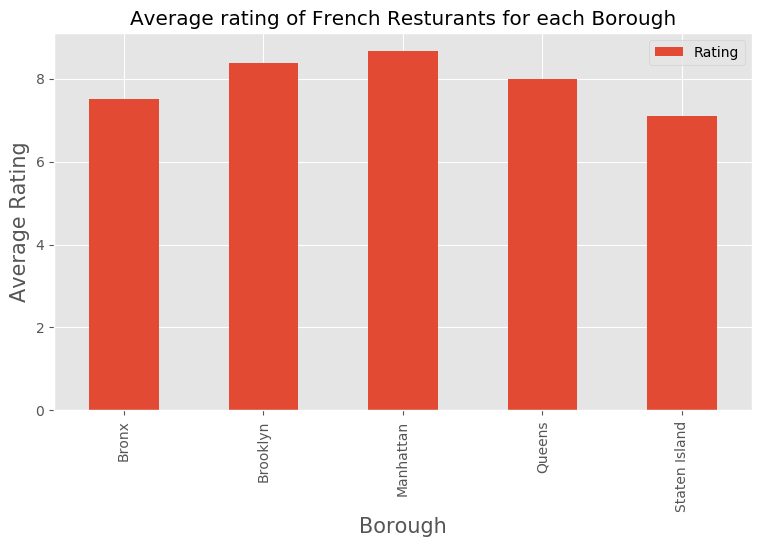

In [170]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of French Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
french_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [171]:
ny_neighborhood_stats = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [172]:
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Chelsea,9.0
17,East Harlem,9.1
28,Little Italy,9.3
40,Soho,9.0
41,South Side,9.1
49,West Village,9.2


**6. Results**

* Manhattan has the most french restaurants among all boroughs in New York
* Unsurprisingly, the average rating of French restaurants in Manhattan is the highest in New York
* The neighbours of Downton and Lincoln Square have the highest number of french restaurants

**7. Conclusion**

1. Following our statistical analysis described in the python notebook, we can say that the best place to open a french restaurant is Manhattan if the selection criteria is based on the fact people assimilate this neighbour as a relational place to french cuisine.

2. A counter intuitive choice would be to open a french restaurant in a place where there’s no french cuisine competition or/and little number of restaurants other than french cuisine and/or far/close to Downtown NYC. But this is out of the scope of this project.